Tamaño del DataFrame original: 2525570
Tamaño del DataFrame muestreado (1%): 25256
Best parameters for Linear Regression: {'regressor__fit_intercept': True}
--- Linear Regression - Test Set Evaluation ---
Mean Squared Error (MSE): 100.47
Mean Absolute Error (MAE): 7.23
R-squared (R2): 0.86

Best parameters for Random Forest Regressor: {'regressor__max_depth': None, 'regressor__n_estimators': 20}
--- Random Forest Regressor - Test Set Evaluation ---
Mean Squared Error (MSE): 24.60
Mean Absolute Error (MAE): 3.29
R-squared (R2): 0.97

--- Feature Coefficients (Absolute Value) - Linear Regression ---
                                              feature  importance
2                num__percentage_by_employment_status   12.965728
56                                 cat__isced11_ED3-8    6.331764
62  cat__education_level_Upper secondary, post-sec...    6.331764
59  cat__education_level_Less than primary, primar...    5.596642
55                                 cat__isced11_ED0-2    5.596642

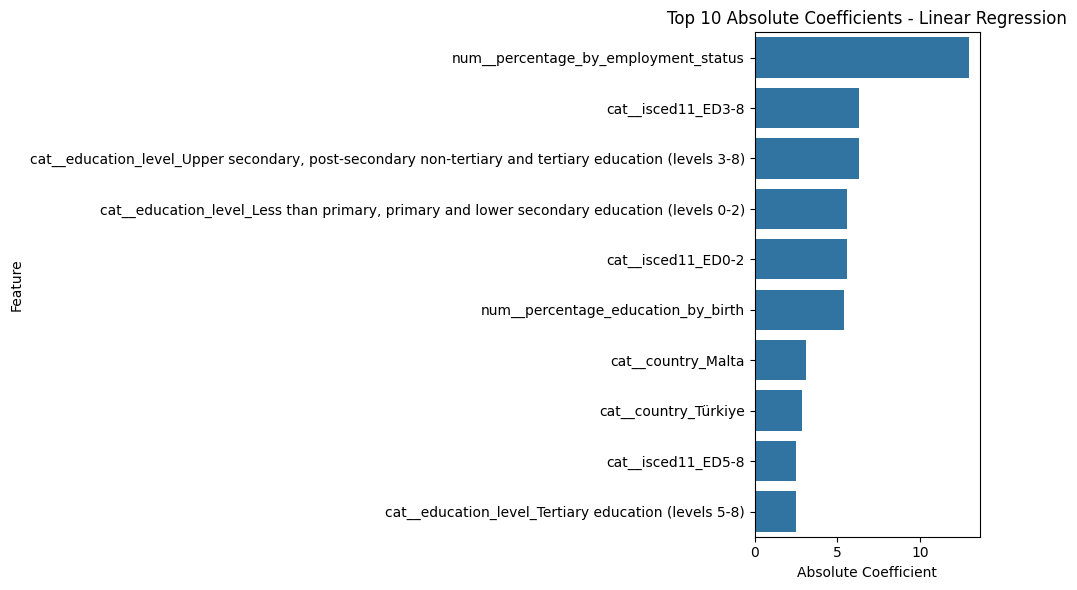


--- Feature Importance - Random Forest Regressor ---
                                              feature  importance
2                num__percentage_by_employment_status    0.750501
62  cat__education_level_Upper secondary, post-sec...    0.035800
56                                 cat__isced11_ED3-8    0.035793
1                  num__percentage_education_by_birth    0.032279
59  cat__education_level_Less than primary, primar...    0.013680
..                                                ...         ...
6                               cat__country_Bulgaria    0.000204
40                        cat__country_United Kingdom    0.000192
54                 cat__Age class_From 55 to 64 years    0.000126
66                               cat__age_group_55-64    0.000114
48                                    cat__age_Y55-64    0.000075

[80 rows x 2 columns]


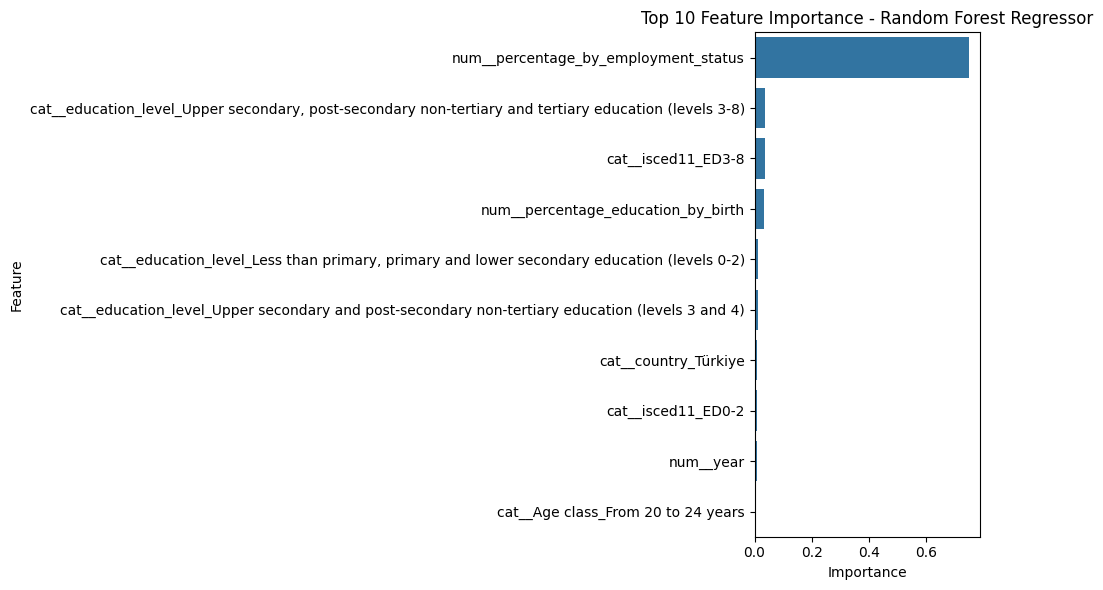

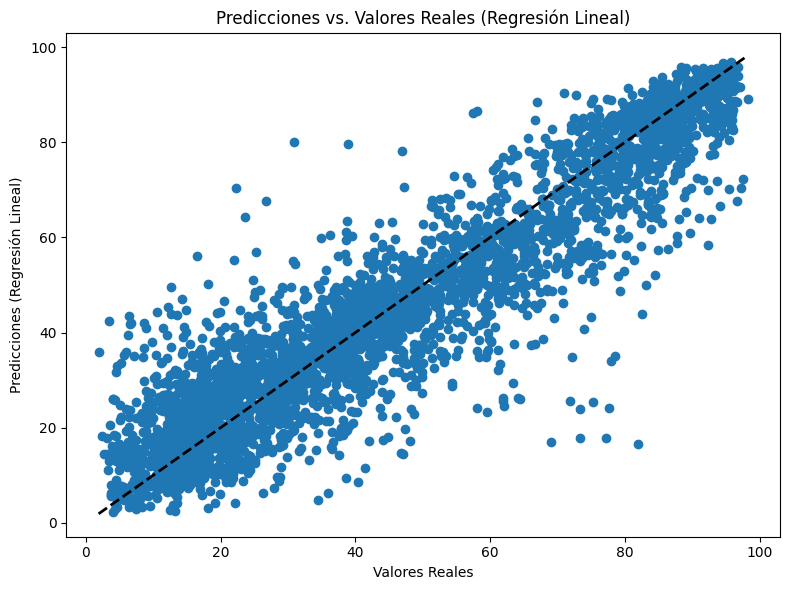

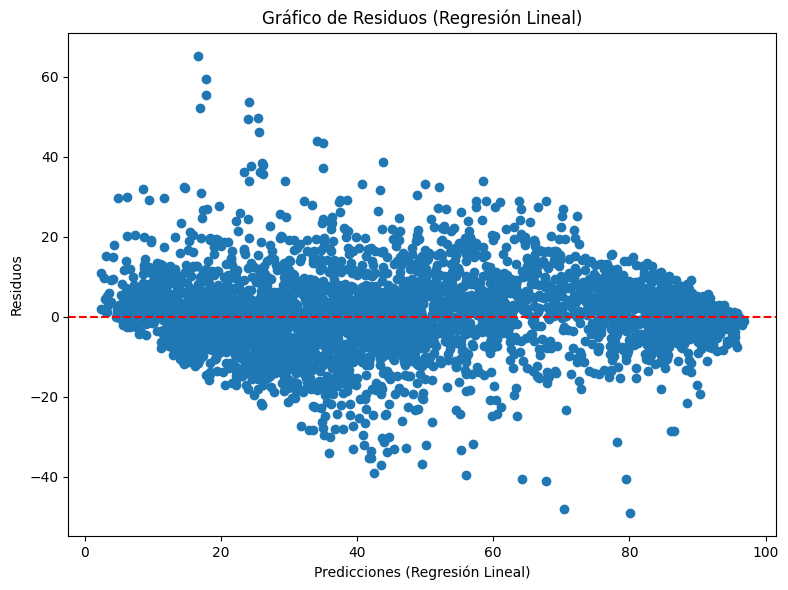

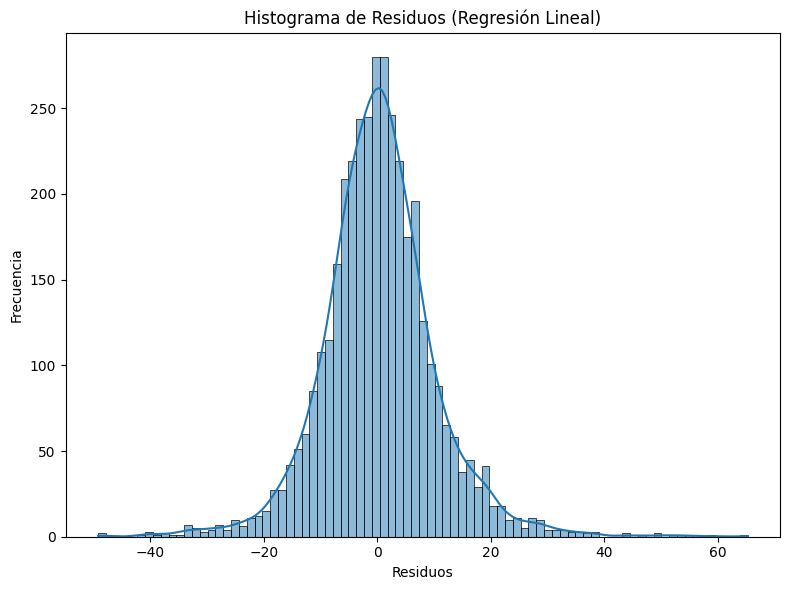

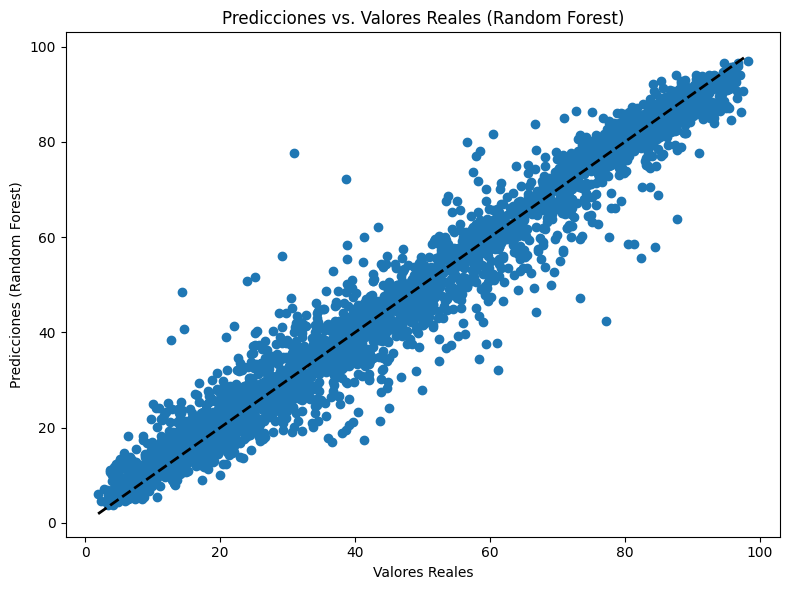

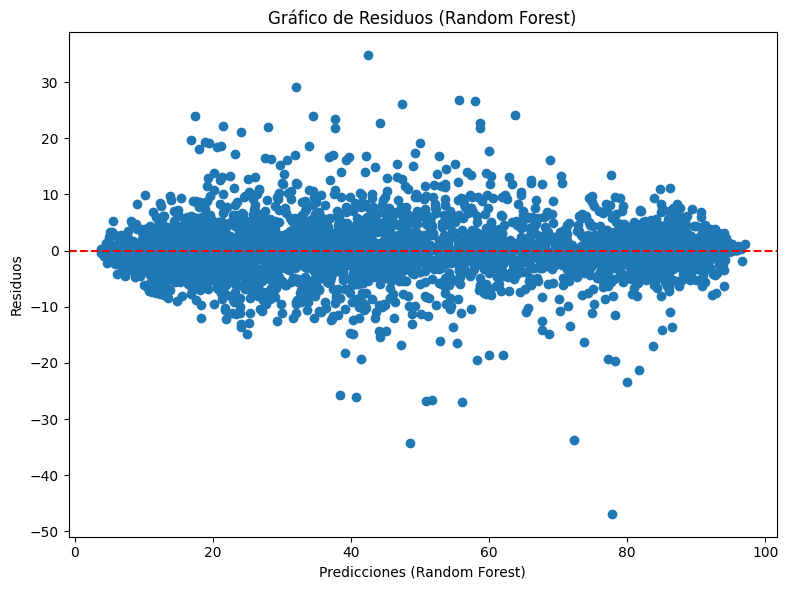

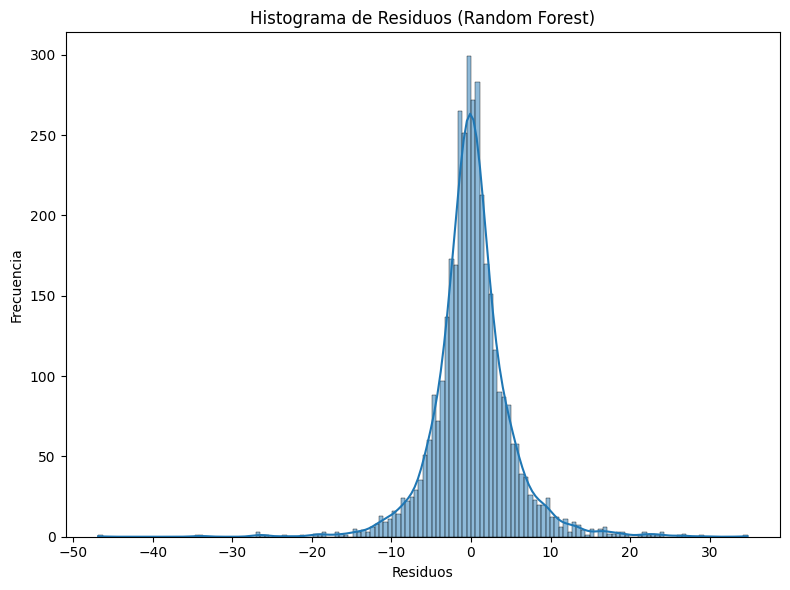

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_regression_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"--- {model_name} - Test Set Evaluation ---")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R-squared (R2): {r2:.2f}")
    return y_pred

def get_feature_importance_regression(model, model_name, feature_names):
    if hasattr(model.named_steps['regressor'], 'feature_importances_'):
        importances = model.named_steps['regressor'].feature_importances_
        feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importance = feature_importance.sort_values('importance', ascending=False)
        print(f"\n--- Feature Importance - {model_name} ---")
        print(feature_importance)
        # Visualización de la importancia de las características (para Random Forest)
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
        plt.title(f'Top 10 Feature Importance - {model_name}')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
    elif hasattr(model.named_steps['regressor'], 'coef_'):
        importances = np.abs(model.named_steps['regressor'].coef_)
        feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importance = feature_importance.sort_values('importance', ascending=False)
        print(f"\n--- Feature Coefficients (Absolute Value) - {model_name} ---")
        print(feature_importance)
        # Visualización de los coeficientes (para Regresión Lineal)
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
        plt.title(f'Top 10 Absolute Coefficients - {model_name}')
        plt.xlabel('Absolute Coefficient')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Feature importance/coefficients not available for {model_name}")

# 1. Cargar el DataFrame limpio para regresión
df_regression = pd.read_csv('data_cleaned_regression.csv')

# 2. Muestreo del 1% del DataFrame (reducido para facilitar la visualización si el original es muy grande)
df_sampled = df_regression.sample(frac=0.01, random_state=42)
print(f"Tamaño del DataFrame original: {len(df_regression)}")
print(f"Tamaño del DataFrame muestreado (1%): {len(df_sampled)}")

# 3. Definir la Variable Objetivo y las Características para Regresión
target_regression = 'percentage_education_general'
features_regression = [col for col in df_sampled.columns if col != target_regression and col != 'nivel_exito']

# 4. Definir características categóricas y numéricas (basado en las columnas presentes)
categorical_features_reg = [col for col in features_regression if df_sampled[col].dtype == 'object']
numerical_features_reg = [col for col in features_regression if df_sampled[col].dtype != 'object']

# 5. Preprocesamiento para Regresión

numerical_transformer_reg = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer_reg = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_reg, numerical_features_reg),
        ('cat', categorical_transformer_reg, categorical_features_reg)
    ])

# 6. Dividir los Datos (División Aleatoria para Regresión)
X_reg = df_sampled[features_regression]
y_reg = df_sampled[target_regression]

X_train_reg, X_temp_reg, y_train_reg, y_temp_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

X_val_reg, X_test_reg, y_val_reg, y_test_reg = train_test_split(
    X_temp_reg, y_temp_reg, test_size=0.5, random_state=42
)
# --- Modelos de Regresión ---

# Regresión Lineal
pipeline_lr_reg = Pipeline(steps=[('preprocessor', preprocessor_reg),
                                   ('regressor', LinearRegression())])
param_grid_lr_reg = {'regressor__fit_intercept': [True, False]}
grid_search_lr_reg = GridSearchCV(pipeline_lr_reg, param_grid_lr_reg, cv=3, scoring='neg_mean_squared_error', verbose=0)
grid_search_lr_reg.fit(X_train_reg, y_train_reg)
best_lr_reg = grid_search_lr_reg.best_estimator_
print("Best parameters for Linear Regression:", grid_search_lr_reg.best_params_)
y_pred_lr = evaluate_regression_model(best_lr_reg, X_test_reg, y_test_reg, "Linear Regression")

# Random Forest Regressor
pipeline_rf_reg = Pipeline(steps=[('preprocessor', preprocessor_reg),
                                   ('regressor', RandomForestRegressor(random_state=42))])
param_grid_rf_reg = {'regressor__n_estimators': [10, 20], 'regressor__max_depth': [5, None]}
grid_search_rf_reg = GridSearchCV(pipeline_rf_reg, param_grid_rf_reg, cv=3, scoring='neg_mean_squared_error', verbose=0)
grid_search_rf_reg.fit(X_train_reg, y_train_reg)
best_rf_reg = grid_search_rf_reg.best_estimator_
print("\nBest parameters for Random Forest Regressor:", grid_search_rf_reg.best_params_)
y_pred_rf = evaluate_regression_model(best_rf_reg, X_test_reg, y_test_reg, "Random Forest Regressor")

# Obtener nombres de las características después del preprocesamiento
feature_names_reg = best_rf_reg.named_steps['preprocessor'].get_feature_names_out()

# Analizar la importancia de las características y generar gráficos
get_feature_importance_regression(best_lr_reg, "Linear Regression", feature_names_reg)
get_feature_importance_regression(best_rf_reg, "Random Forest Regressor", feature_names_reg)

# --- Visualizaciones Adicionales ---

# 1. Gráfico de Dispersión de Predicciones vs. Valores Reales (Regresión Lineal)
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_lr)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones (Regresión Lineal)')
plt.title('Predicciones vs. Valores Reales (Regresión Lineal)')
plt.tight_layout()
plt.show()

# 2. Gráfico de Residuos (Regresión Lineal)
residuals_lr = y_test_reg - y_pred_lr
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_lr, residuals_lr)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicciones (Regresión Lineal)')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos (Regresión Lineal)')
plt.tight_layout()
plt.show()

# 3. Histograma de Residuos (Regresión Lineal)
plt.figure(figsize=(8, 6))
sns.histplot(residuals_lr, kde=True)
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Residuos (Regresión Lineal)')
plt.tight_layout()
plt.show()

# 4. Gráfico de Dispersión de Predicciones vs. Valores Reales (Random Forest)
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_rf)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones (Random Forest)')
plt.title('Predicciones vs. Valores Reales (Random Forest)')
plt.tight_layout()
plt.show()

# 5. Gráfico de Residuos (Random Forest)
residuals_rf = y_test_reg - y_pred_rf
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_rf, residuals_rf)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicciones (Random Forest)')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos (Random Forest)')
plt.tight_layout()
plt.show()

# 6. Histograma de Residuos (Random Forest)
plt.figure(figsize=(8, 6))
sns.histplot(residuals_rf, kde=True)
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Residuos (Random Forest)')
plt.tight_layout()
plt.show()